### Dimensionality Reduction 
#### Part I
Comparing PCA and tSNE, the two gold standards for dimensionality reduction

In [1]:
%matplotlib inline
import tSNE_utils # load utility functions from local file

import numpy as np
np.seterr(divide='ignore', invalid='ignore') # allow divide by zero for normalization
import pandas as pd
import scipy as sc

# scikit packages
import skbio
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import tsne packages
from sklearn.manifold import TSNE
import sys; sys.path.append('/Users/Cody/git/FIt-SNE')
from fast_tsne import fast_tsne

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'whitegrid')

Load _.hdf5_ filetype using `h5py`

In [2]:
%%time

#load the hdf5 files into objects
r00 = tSNE_utils.read_hdf5("inputs/GSE102698ClosenessRep_0.hdf5")
#r01 = tSNE_utils.read_hdf5("inputs/GSE102698ClosenessRep_1.hdf5")
#r02 = tSNE_utils.read_hdf5("inputs/GSE102698ClosenessRep_2.hdf5")

CPU times: user 2.57 s, sys: 506 ms, total: 3.08 s
Wall time: 3.17 s


Each matrix should be __375 cells__ wide and __25507 genes__ long

In [3]:
print('r00 = {}'.format(r00['Close_0.25'].shape)) # for example

r00 = (375, 25507)


save this one to a `.csv` file for later use in scVI

In [16]:
np.savetxt(X=r00['Close_0.00'],fname='little_test.csv',delimiter=',')

In [54]:
values = r00['Close_0.00'].T
index = ['Row'+str(i) for i in range(1, len(values)+1)]

df = pd.DataFrame(values, index=index)

df.to_csv('little_test_labels.csv')

Calculate a distance matrix for all 375 cells in one of the datasets using `scipy` spatial distance function

In [4]:
# replicate 1 with closeness value 0.00
%time dm_r00_000 = sc.spatial.distance_matrix(x=r00['Close_0.00'],y=r00['Close_0.00'])
# should be (375,375)
dm_r00_000.shape

CPU times: user 13.2 s, sys: 3.6 s, total: 16.8 s
Wall time: 16.9 s


(375, 375)

---
#### Perform PCA
50-component analysis on log2-normalized raw RNA-seq data

In [5]:
%%time
# PCA with 50 PCs on raw data
r00_000_rawPCA_fit = PCA(n_components=50).fit(r00['Close_0.00'])
# transform data to fit
r00_000_rawPCA = r00_000_rawPCA_fit.transform(r00['Close_0.00'])

# PCA with 50 PCs on arcsinh-transformed data
sinh_norm = tSNE_utils.arcsinh_norm(r00['Close_0.00'])
r00_000_sinhPCA_fit = PCA(n_components=50).fit(sinh_norm)
# transform data to fit
r00_000_sinhPCA = r00_000_sinhPCA_fit.transform(sinh_norm)

# PCA with 50 PCs on log2-transformed data
log2_norm = tSNE_utils.log2_norm(r00['Close_0.00'])
r00_000_logPCA_fit = PCA(n_components=50).fit(log2_norm)
# transform data to fit
r00_000_logPCA = r00_000_logPCA_fit.transform(log2_norm)

CPU times: user 3.09 s, sys: 248 ms, total: 3.34 s
Wall time: 1.71 s


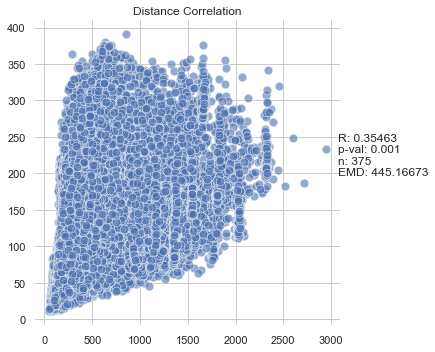

(0.3546296111805311, 0.001, 375)

In [6]:
tSNE_utils.compare_euclid(pre = r00['Close_0.00'], post = r00_000_sinhPCA)

In [8]:
%%time
# calculate distance correlation statistics and plot scatter of cell-cell distances between raw data and normalized data
dm_r00_000_sinh = sc.spatial.distance_matrix(x=sinh_norm, y=sinh_norm)
dm_r00_000_log2 = sc.spatial.distance_matrix(x=log2_norm, y=log2_norm)
raw_sinh_corr = tSNE_utils.corr_distances(dm_r00_000, dm_r00_000_sinh, plot_out=False)
raw_log2_corr = tSNE_utils.corr_distances(dm_r00_000, dm_r00_000_log2, plot_out=False)
sinh_log2_corr = tSNE_utils.corr_distances(dm_r00_000_sinh, dm_r00_000_log2, plot_out=False)

print('Raw to sinh-transformed: R = {}\nRaw to log2-transformed: R = {}\nsinh-transformed to log2-transformed: R = {}\n'.format(raw_sinh_corr[0],raw_log2_corr[0],sinh_log2_corr[0]))

Raw to sinh-transformed fractional: R = 0.3787308253370049
Raw to log2-transformed: R = 0.3482225215328997
sinh-transformed fractional to log2-transformed: R = 0.9362657653872295

CPU times: user 29.4 s, sys: 14.7 s, total: 44.2 s
Wall time: 44.8 s


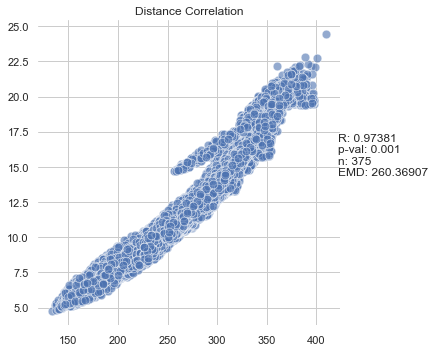

(0.97381391607823686, 0.001, 375)

In [8]:
# good correlation of the two transformed datasets.... let's take a closer look
tSNE_utils.compare_euclid(sinh_norm, log2_norm)

Text(0.5, 1.0, 'PCA Analysis - log2-transformed')

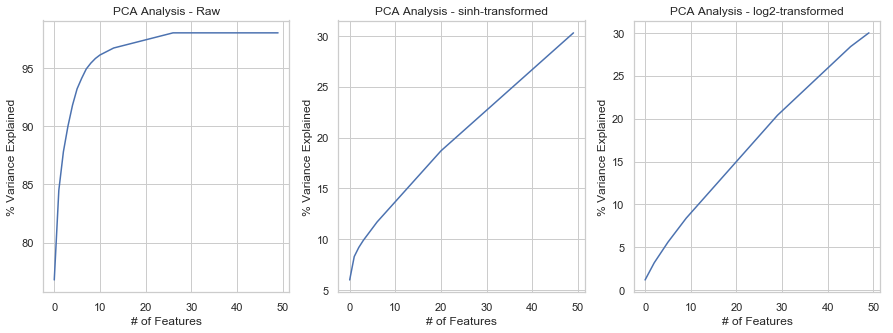

In [11]:
# generate a skree plot showing the explained variance 
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(np.cumsum(np.round(r00_000_rawPCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - Raw') 

plt.subplot(132)
plt.plot(np.cumsum(np.round(r00_000_sinhPCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - sinh-transformed')

plt.subplot(133)
plt.plot(np.cumsum(np.round(r00_000_logPCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - log2-transformed')

From the above data, it seems like the `arcsinh(fractional_coverage*1000)` transformation is the best input to PCA because:
1. it preserves euclidean cell-cell distances slightly better than log2-transformation (larger R value from Mantel test)
2. it generates a PCA that has more variability explained by its initial components (see Skree plots above)

In [12]:
# generate distance matrix for PCA results
%time dm_r00_000_PCA = sc.spatial.distance_matrix(x=r00_000_sinhPCA,y=r00_000_sinhPCA)

CPU times: user 32.1 ms, sys: 2.49 ms, total: 34.6 ms
Wall time: 35.5 ms


(375, 375)


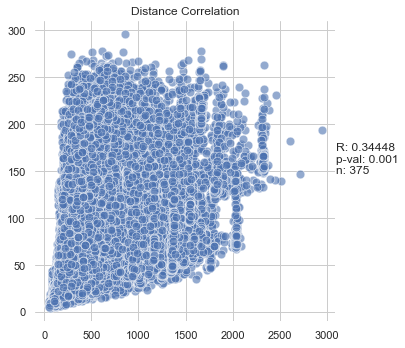

CPU times: user 2.04 s, sys: 25.4 ms, total: 2.07 s
Wall time: 2.08 s


In [13]:
# calculate distance correlation statistics and plot scatter of cell-cell distances between raw data and PCA
print(dm_r00_000_PCA.shape)
%time raw_PCA_corr = tSNE_utils.corr_distances(dm_r00_000,dm_r00_000_PCA)

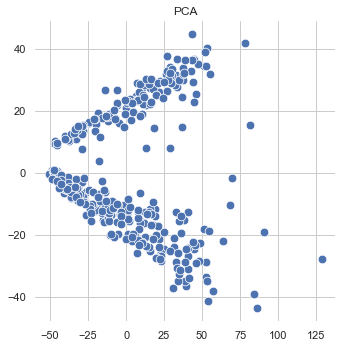

In [14]:
# Plot principal component analysis
plt.figure(figsize=(5,5))

sns.scatterplot(r00_000_sinhPCA[:,0], r00_000_sinhPCA[:,1], s=75)
plt.title('PCA')

sns.despine(left=True, bottom=True)
plt.tight_layout()

seems like there ar two distinct clusters, denoted by the value of their second principal component  
let's try to cluster them using `sklearn`

In [71]:
# cluster PCA results using k-means
cluster_fit = KMeans(n_clusters=2, max_iter=1000).fit(r00_000_sinhPCA)
clusters = cluster_fit.predict(r00_000_sinhPCA)

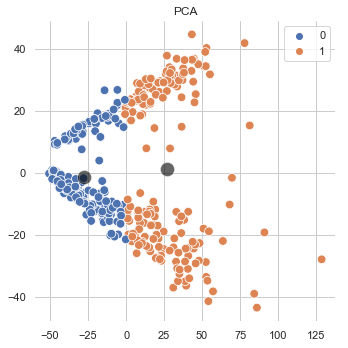

In [72]:
# Plot principal component analysis
plt.figure(figsize=(5,5))

sns.scatterplot(r00_000_sinhPCA[:,0], r00_000_sinhPCA[:,1], s=75, hue=clusters) # color plot by clusters
sns.scatterplot(cluster_fit.cluster_centers_[:,0], cluster_fit.cluster_centers_[:,1], s=200, alpha=0.6, color='black') # plot cluster centers
plt.title('PCA')

sns.despine(left=True, bottom=True)
plt.tight_layout()

---
#### Perform tSNE
use output of 50-component PCA to prime tSNE  
`sklearn` implementation of tSNE

In [33]:
# This uses perplexity=30 (default) and random initialisation
%time r00_000_tSNE = TSNE(n_components=2).fit_transform(r00_000_sinhPCA)
# resulting matrix should be (375,2)
r00_000_tSNE.shape

CPU times: user 1.85 s, sys: 11 ms, total: 1.86 s
Wall time: 1.9 s


(375, 2)

In [34]:
# generate distance matrix for t-SNE results
dm_r00_000_tSNE = sc.spatial.distance_matrix(x=r00_000_tSNE,y=r00_000_tSNE)

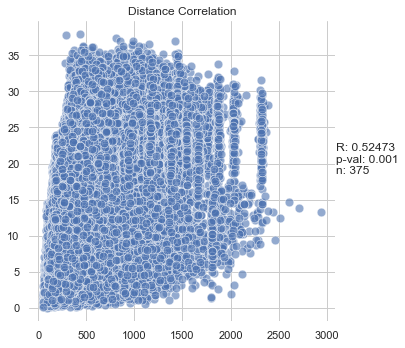

CPU times: user 2.07 s, sys: 23.8 ms, total: 2.1 s
Wall time: 2.13 s


In [37]:
# calculate distance correlation statistics and plot scatter of cell-cell distances between raw data and t-SNE
%time raw_tSNE_corr = tSNE_utils.corr_distances(dm_r00_000,dm_r00_000_tSNE)

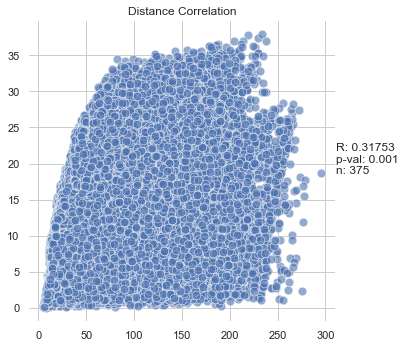

CPU times: user 2.2 s, sys: 79.6 ms, total: 2.28 s
Wall time: 2.23 s


In [38]:
# calculate distance correlation statistics and plot scatter of cell-cell distances between PCA and t-SNE
%time raw_tSNE_corr = tSNE_utils.corr_distances(dm_r00_000_PCA,dm_r00_000_tSNE)

In [73]:
# cluster tSNE results using k-means
cluster_fit_tSNE = KMeans(n_clusters=2).fit(r00_000_tSNE)
clusters_tSNE = cluster_fit_tSNE.predict(r00_000_tSNE)

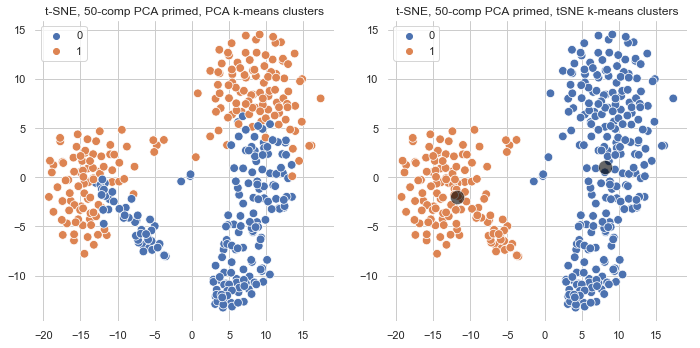

In [74]:
# plot results
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(r00_000_tSNE[:,0], r00_000_tSNE[:,1], s=75, hue=clusters)
plt.title('t-SNE, 50-comp PCA primed, PCA k-means clusters')

plt.subplot(122)
sns.scatterplot(r00_000_tSNE[:,0], r00_000_tSNE[:,1], s=75, hue=clusters_tSNE)
sns.scatterplot(cluster_fit_tSNE.cluster_centers_[:,0], cluster_fit_tSNE.cluster_centers_[:,1], s=200, alpha=0.6, color='black')
plt.title('t-SNE, 50-comp PCA primed, tSNE k-means clusters')

sns.despine(left=True, bottom=True)
plt.tight_layout()

---
#### Perform tSNE
use output of 50-component PCA to prime tSNE  
__FIt-SNE__ implementation (https://github.com/KlugerLab/FIt-SNE) as recommended by:  
Kobak, D., & Berens, P. (2018). The art of using t-SNE for single-cell transcriptomics. https://doi.org/10.1101/453449

In [75]:
# This uses perplexity=30 (default) and random initialisation
%time r00_000_FItSNE = fast_tsne(r00_000_sinhPCA,seed=18,perplexity=30)
r00_000_FItSNE.shape

CPU times: user 3.64 ms, sys: 13.8 ms, total: 17.4 ms
Wall time: 13.7 s


(375, 2)

In [76]:
# generate distance matrix for FIt-SNE results
dm_r00_000_FItSNE = sc.spatial.distance_matrix(x=r00_000_FItSNE,y=r00_000_FItSNE)
dm_r00_000_FItSNE.shape

(375, 375)

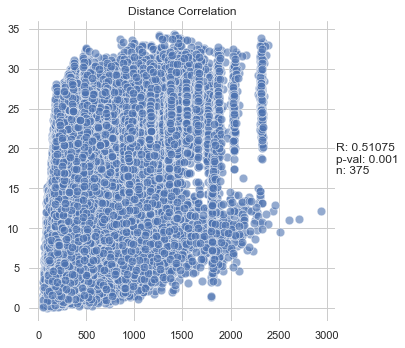

CPU times: user 2.98 s, sys: 42.9 ms, total: 3.02 s
Wall time: 3.37 s


In [77]:
# calculate distance correlation statistics and plot scatter of cell-cell distances between raw data and FIt-SNE
%time raw_FItSNE_corr = tSNE_utils.corr_distances(dm_r00_000,dm_r00_000_FItSNE)

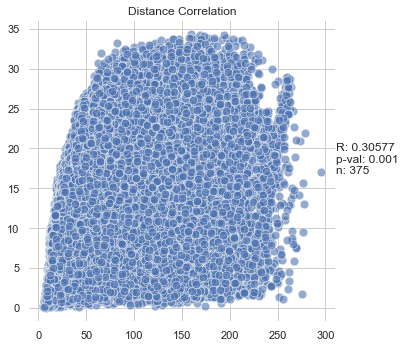

CPU times: user 3.1 s, sys: 29.9 ms, total: 3.13 s
Wall time: 3.19 s


In [78]:
# calculate distance correlation statistics and plot scatter of cell-cell distances between PCA and FIt-SNE
%time raw_FItSNE_corr = tSNE_utils.corr_distances(dm_r00_000_PCA,dm_r00_000_FItSNE)

In [79]:
# cluster tSNE results using k-means
cluster_fit_FItSNE = KMeans(n_clusters=2).fit(r00_000_FItSNE)
clusters_FItSNE = cluster_fit_FItSNE.predict(r00_000_FItSNE)

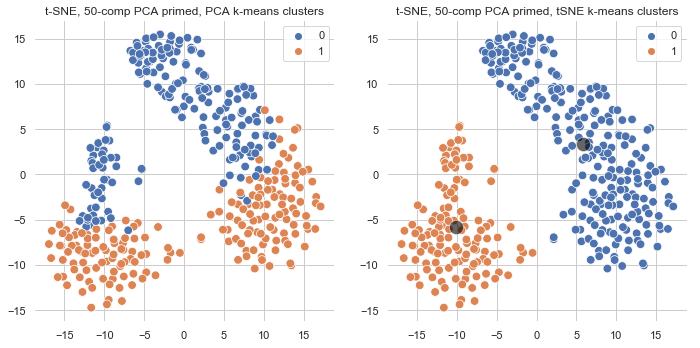

In [81]:
# plot results
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(r00_000_FItSNE[:,0], r00_000_FItSNE[:,1], s=75, hue=clusters)
plt.title('t-SNE, 50-comp PCA primed, PCA k-means clusters')

plt.subplot(122)
sns.scatterplot(r00_000_FItSNE[:,0], r00_000_FItSNE[:,1], s=75, hue=clusters_FItSNE)
sns.scatterplot(cluster_fit_FItSNE.cluster_centers_[:,0], cluster_fit_FItSNE.cluster_centers_[:,1], s=200, alpha=0.6, color='black')
plt.title('t-SNE, 50-comp PCA primed, tSNE k-means clusters')

sns.despine(left=True, bottom=True)
plt.tight_layout()

---
#### scVI
Let's try scVI DR

In [17]:
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
from scvi.dataset import CsvDataset

In [36]:
# Loading a local dataset 
local_csv_dataset = CsvDataset('little_test.csv', save_path='./', gene_by_cell=False, new_n_genes=False) 

File ./little_test.csv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [52]:
# kept all genes
local_csv_dataset.nb_genes

25506

**Train the model and output model likelihood every 5 epochs**

In [39]:
vae = VAE(local_csv_dataset.nb_genes)
trainer = UnsupervisedTrainer(vae,
                              local_csv_dataset,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=0.001)

training:   9%|███████▎                                                                            | 35/400 [01:44<18:05,  2.97s/it]


KeyboardInterrupt: 

**Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

(1000, 7500)

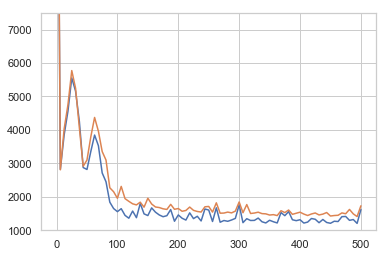

In [28]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(1000,7500)